In [3]:
import os
from PIL import Image
from utils import *
import torch
from diffusers import StableDiffusionPipeline

device = "cuda:0"

/home/reproducepark/anaconda3/envs/cs492d/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Stable Diffusion

In [4]:
pipe = StableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4", 
    torch_dtype=torch.float16,
    safety_checker=None,
    feature_extractor=None,
)

print("[INFO] Successfully loaded Stable Diffusion!")

Loading pipeline components...:  80%|████████  | 4/5 [00:02<00:00,  1.90it/s]/home/reproducepark/anaconda3/envs/cs492d/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Loading pipeline components...: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in

[INFO] Successfully loaded Stable Diffusion!


### Load LoRA weights

In [5]:
lora_path = "./runs/sd-naruto-model-lora"
# lora_path = "./runs/artistic_custom"
# lora_path = "./runs/dreambooth_cat"
# lora_path = None  # if not using LoRA

if lora_path is not None:
    pipe.load_lora_weights(lora_path)
    print("[INFO] Successfully loaded LoRA weights!")
    
pipe = pipe.to(device)

[INFO] Successfully loaded LoRA weights!


### Inference

100%|██████████| 30/30 [00:01<00:00, 22.35it/s]


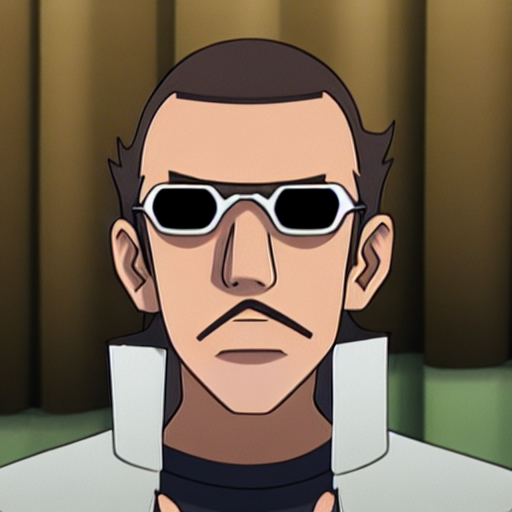

In [8]:
prompt = "a man with sunglasses"

seed = 1

seed_everything(seed)

image = pipe(
    prompt, 
    num_inference_steps=30, 
    guidance_scale=11.5,
).images[0]

image

100%|██████████| 30/30 [00:01<00:00, 26.28it/s]


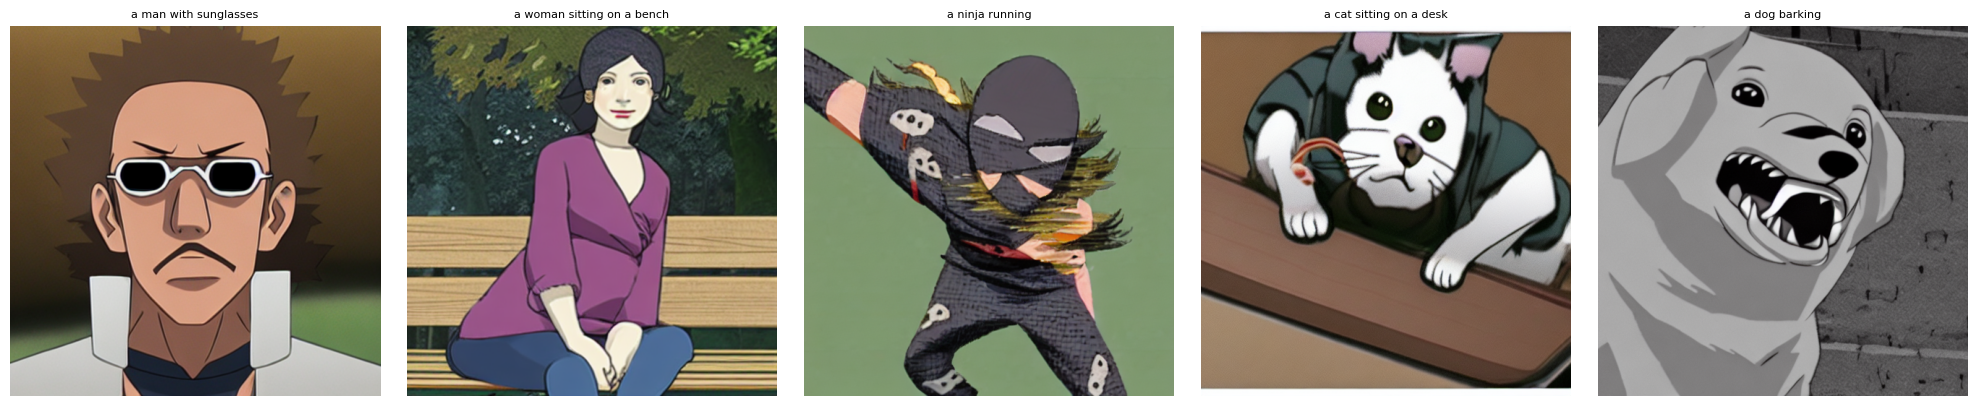

In [13]:
import matplotlib.pyplot as plt

prompts = [
    "a man with sunglasses",
    "a woman sitting on a bench",
    "a ninja running",
    "a cat sitting on a desk",
    "a dog barking",
]

seed = 1
seed_everything(seed)

images = []
for p in prompts:
    img = pipe(
        p,
        num_inference_steps=30,
        guidance_scale=7.5,
    ).images[0]
    images.append(img)

plt.figure(figsize=(20, 4))
for i, (p, img) in enumerate(zip(prompts, images)):
    ax = plt.subplot(1, len(prompts), i + 1)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(p, fontsize=8)

plt.tight_layout()
plt.show()


In [ ]:
from safetensors.torch import load_file

state = load_file("./runs/sd-naruto-model-lora/pytorch_lora_weights.safetensors")
for key in state.keys():
    print(key)


unet.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_k.lora.down.weight
unet.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_k.lora.up.weight
unet.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_out.0.lora.down.weight
unet.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_out.0.lora.up.weight
unet.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q.lora.down.weight
unet.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q.lora.up.weight
unet.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_v.lora.down.weight
unet.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_v.lora.up.weight
unet.down_blocks.0.attentions.0.transformer_blocks.0.attn2.to_k.lora.down.weight
unet.down_blocks.0.attentions.0.transformer_blocks.0.attn2.to_k.lora.up.weight
unet.down_blocks.0.attentions.0.transformer_blocks.0.attn2.to_out.0.lora.down.weight
unet.down_blocks.0.attentions.0.transformer_blocks.0.attn2.to_out.0.lora.up.weight
unet.down_blocks.0.atten

In [24]:
from safetensors.torch import load_file

state = load_file("./runs/sd-naruto-model-lora/pytorch_lora_weights.safetensors")

for key, weight in state.items():
    if "unet.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_k.lora.down.weight" in key:
        print("shape:", weight.shape)

        # rank는 lora_down의 첫 번째 dimension
        r = weight.shape[0]
        print("LoRA rank =", r)
        break


shape: torch.Size([4, 320])
LoRA rank = 4


In [17]:
from diffusers import UNet2DConditionModel
model = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

print(model)
    




UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe